In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

### Loading the dataset

In [2]:
DATASET_PATH = '../datasets/hydroshoot_impulse_v2.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset

dataset = ExperimentDataset(csv_path=DATASET_PATH)
print(dataset)

Dataset properties:
	n_runs:      11
	n_steps:    240
	state_size: 360

Available targets: 
	input_Tac, input_u, input_hs, input_Rg, output_Rg, output_An, output_E, output_Tleaf

Available state variables: 
	state_psi_head, state_Tlc, state_Flux, state_Eabs, state_Ei, state_E, state_FluxC, state_An, state_Ci, state_u, state_gs, state_gb, state_par_photo.dHd



In [4]:
dataset.get_run_ids()

array(['2012-08-01__width0__0', '2012-08-01__width1__0',
       '2012-08-01__width1__1500', '2012-08-01__width3__0',
       '2012-08-01__width3__1500', '2012-08-01__width5__0',
       '2012-08-01__width5__1500', '2012-08-01__width7__0',
       '2012-08-01__width7__1500', '2012-08-01__width9__0',
       '2012-08-01__width9__1500'], dtype=object)

### Figures

In [5]:
def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var(axis=0) + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = ((base_state - state)**2 / norm_factor).mean()
  return dist


def get_data(run1, run2, state):
  # get raw data
  data1 = dataset.get_state(state, run1)[START:STOP]
  data2 = dataset.get_state(state, run2)[START:STOP]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

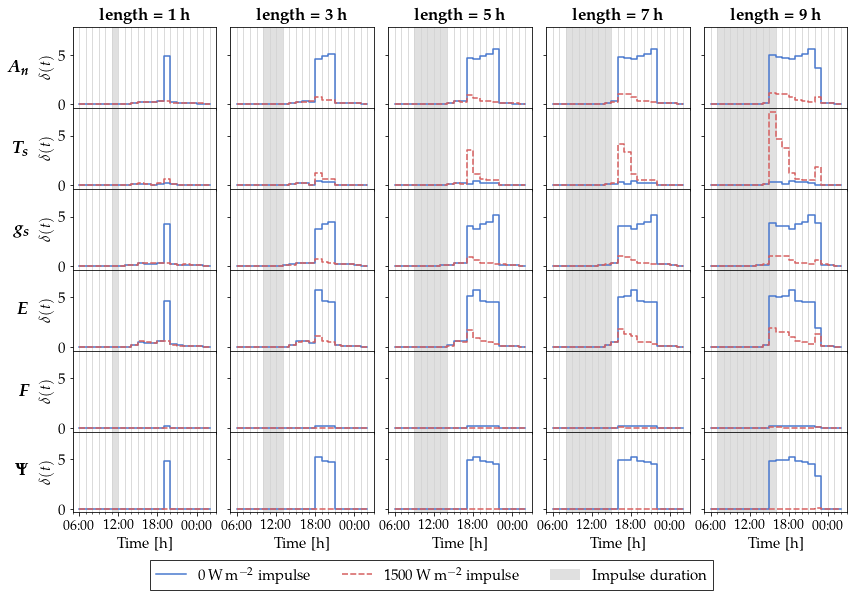

In [206]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

reservoirs = [
  'state_An',
  'state_Tlc',
  'state_gs',
  'state_E', 
  'state_Flux',
  'state_psi_head',
]

symbols = {
  'state_An': r'$A_n$',
  'state_Tlc': r'$T_s$',
  'state_gs': r'$g_s$',
  'state_E': r'$E$',
  'state_Flux': r'$F$',
  'state_psi_head': r'$\Psi$',
}

symbols_bold = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in symbols.items()}

widths = [1, 3, 5, 7, 9]

intervals = [
    (12, 13),  # width 1
    (11, 14),  # width 3
    (10, 15),  # width 5
    ( 9, 16),  # width 7
    ( 8, 17),  # width 9
 ]

baseline = '2012-08-01__width0__0'
template = lambda width, value: f'2012-08-01__width{width}__{value}'

START = 24 * 4 + 6
STOP = 24 * 6 - 18 - 3


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(12, 8), sharex=True, sharey=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  for row, (state, axs_row) in enumerate(zip(reservoirs, axs)):
    for col, (width, (p0, p1), ax) in enumerate(zip(widths, intervals, axs_row)):
      # get data
      pulse_lo = get_data(baseline, template(width, 0), state)
      pulse_hi = get_data(baseline, template(width, 1500), state)
      div = np.array([pulse_lo, pulse_hi])
      df = pd.DataFrame(div.T)
      df.columns = [
        r'\SI{0}{\watt\per\square\meter} impulse', 
        r'\SI{1500}{\watt\per\square\meter} impulse'
      ]
      df.index = np.arange(START, STOP)

      # plot data
      sns.lineplot(data=df, ax=ax, palette=plot_colors, drawstyle='steps-pre')

      # color impulse steps
      ax.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration')

      # x axis
      xticks = np.arange(START, STOP, 1)
      ax.set_xticks(xticks)
      xticklabels = generate_xticklabels(xticks)
      xticklabels = [label if not (i) % 6 else '' for i, label in enumerate(xticklabels)]
      ax.set_xticklabels(xticklabels, fontsize=14)

      # gridlines and tick size
      ax.xaxis.set_major_locator(MultipleLocator(6))
      ax.xaxis.set_minor_locator(MultipleLocator(1))
      ax.grid(axis='x', linestyle='solid', color='lightgrey', which='both')

      # labeling
      ax.set_xlabel(r'Time [\unit{\hour}]')
      ax.set_ylabel(r'$\delta(t)$')
      if col == 0:
        ax.annotate(symbols_bold[state], (-0.31, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=18)
      if row == 0:
        ax.annotate(f'\\textbf{{length = {width} h}}', (0.5, 1.1), xycoords='axes fraction', ha='center', fontsize=17)

      # cleanup
      ax.get_legend().remove()
      if ax is axs[0][0]:
        fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                    frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.05), fontsize=15)
        
  
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0)  
  plt.savefig('impulse_reservoirs_hydroshoot.png', dpi=200, facecolor='white', bbox_inches='tight')


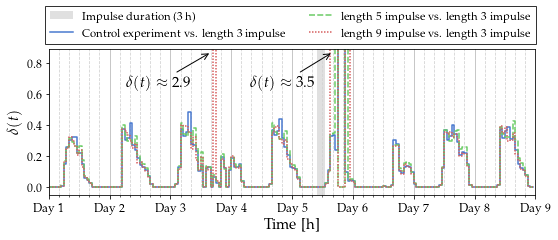

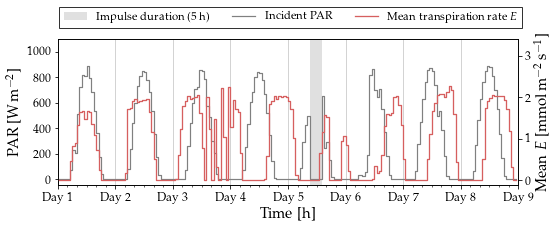

In [224]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FuncFormatter)

reservoir = 'state_E'
symbol_res = {'state_E': r'$\boldsymbol{E}$'}
pulse_width = 5
pulse_interval = (10, 15)
p0, p1 = pulse_interval

baseline = '2012-08-01__width0__0'
experiment1 = f'2012-08-01__width3__0'
experiment2 = f'2012-08-01__width5__0'
experiment3 = f'2012-08-01__width9__0'

START = 0 * 24
STOP = 8 * 24


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    if x % 24 == 0:
      labels.append(f'Day {x // 24 + 1}')
    elif x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(1, 1, figsize=(8, 3), sharex=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  ### TOP AX: RESERVOIR DIVERGENCE FOR ENTIRE EXPERIMENT ###
  try:
    # prep data
    div_1 = get_data(baseline, experiment1, reservoir)
    div_2 = get_data(experiment2, experiment1, reservoir)
    div_3 = get_data(experiment3, experiment1, reservoir)
    div = np.array([div_1, div_2, div_3])
    df = pd.DataFrame(div.T)
    df.columns = [r'Control experiment vs. length 3 impulse', 
                  r'length 5 impulse vs. length 3 impulse', 
                  r'length 9 impulse vs. length 3 impulse']
    df.index = np.arange(START, STOP)

    # plot data
    ax1.axvspan(4 * 24 + 11 - 1, 4 * 24 + 14 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration (\\SI{3}{\hour})')
    sns.lineplot(data=df, ax=ax1, drawstyle='steps-pre')

    # Axes
    ax1.set_xlim(START, STOP)
    ax1.set_ylim(-0.05, 0.89)
    ax1.xaxis.set_minor_locator(MultipleLocator(4))
    ax1.xaxis.set_major_locator(MultipleLocator(24))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'Day {x // 24 + 1:.0f}'))
    ax1.grid(axis='x', linestyle='solid', color='darkgrey', alpha=.65, linewidth=1, which='major')
    ax1.grid(axis='x', linestyle='dashed', color='lightgrey', which='minor')
    ax1.tick_params(axis='both', which='both', labelsize=12)
    
    # Labeling
    ax1.set_ylabel(r'$\delta(t)$')
    ax1.set_xlabel(r'Time [\unit{\hour}]')
    ax1.get_legend().remove()
    ax1.annotate(r"$\delta(t) \approx 2.9$", xy=(2 * 24 + 16, 0.87), 
                xytext=(2 * 24 + 8, 0.65), arrowprops=dict(arrowstyle="->"), ha='right')
    ax1.annotate(r"$\delta(t) \approx 3.5$", xy=(4 * 24 + p0 + 6, 0.87), 
                xytext=(4 * 24 + p0 + -1, 0.65), arrowprops=dict(arrowstyle="->"), ha='right')

    fig.legend(loc='upper center', fancybox=False, shadow=False, ncol=2, 
              frameon=True, edgecolor='black', bbox_to_anchor=(0.52, 1.15), fontsize=11.5)
    plt.tight_layout()
    plt.savefig('hydroshoot_instability_divergence.png', dpi=200, facecolor='white', bbox_inches='tight')
  except:
    pass

  ### BOTTOM AX: ACTUAL DATA ###
  try:
    fig, ax2 = plt.subplots(1, 1, figsize=(8, 3), sharex=True)
    colors = sns.color_palette()
    plot_colors = colors[0], colors[2]

    # prep data
    input_PAR = dataset.get_target('input_Rg', f'2012-08-01__width{pulse_width}__0')[START:STOP]
    res_series = dataset.get_state(reservoir, f'2012-08-01__width{pulse_width}__0')[START:STOP]
    np.random.seed(42)
    res_series = res_series.mean(axis=1)
    
    # plot_data
    time = np.arange(START, STOP)
    ax2.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration (\SI{5}{\hour})')
    ax2.plot(time, input_PAR, color='grey', marker='s', markersize=0, drawstyle='steps-pre',
            label='Incident PAR', linewidth=1.2)
    res_ax = ax2.twinx()
    res_ax.plot(time, res_series * 1000, color=colors[2], linestyle='solid', marker='^', 
                markersize=0, drawstyle='steps-pre', label='Mean transpiration rate $E$', linewidth=1.3)

    # Axes
    ax2.set_xlim(START, STOP)
    ax2.set_ylim(top=1100)
    res_ax.set_ylim(top=3.4)
    ax2.xaxis.set_minor_locator(MultipleLocator(4))
    ax2.xaxis.set_major_locator(MultipleLocator(24))
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'Day {x // 24 + 1:.0f}'))
    ax2.grid(axis='x', linestyle='solid', color='lightgrey', alpha=1, linewidth=1, which='major')
    ax2.tick_params(axis='both', which='both', labelsize=12)
    res_ax.tick_params(axis='both', which='both', labelsize=12)

    # Labeling
    ax2.legend(loc='upper left').remove()
    res_ax.legend(loc='upper right').remove()
    ax2.set_ylabel(r'PAR [\unit{\watt\per\square\meter}]')
    res_ax.set_ylabel(r'Mean $E$ [\unit{\milli\mol\per\square\meter\per\second}]')
    ax2.set_xlabel(r'Time [\unit{\hour}]')

    fig.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, 
              frameon=True, edgecolor='black', bbox_to_anchor=(0.52, 1.1), fontsize=11.5)
    plt.tight_layout()
    plt.savefig('hydroshoot_instability_behavior.png', dpi=200, facecolor='white', bbox_inches='tight')
  except:
    pass

### Inputs

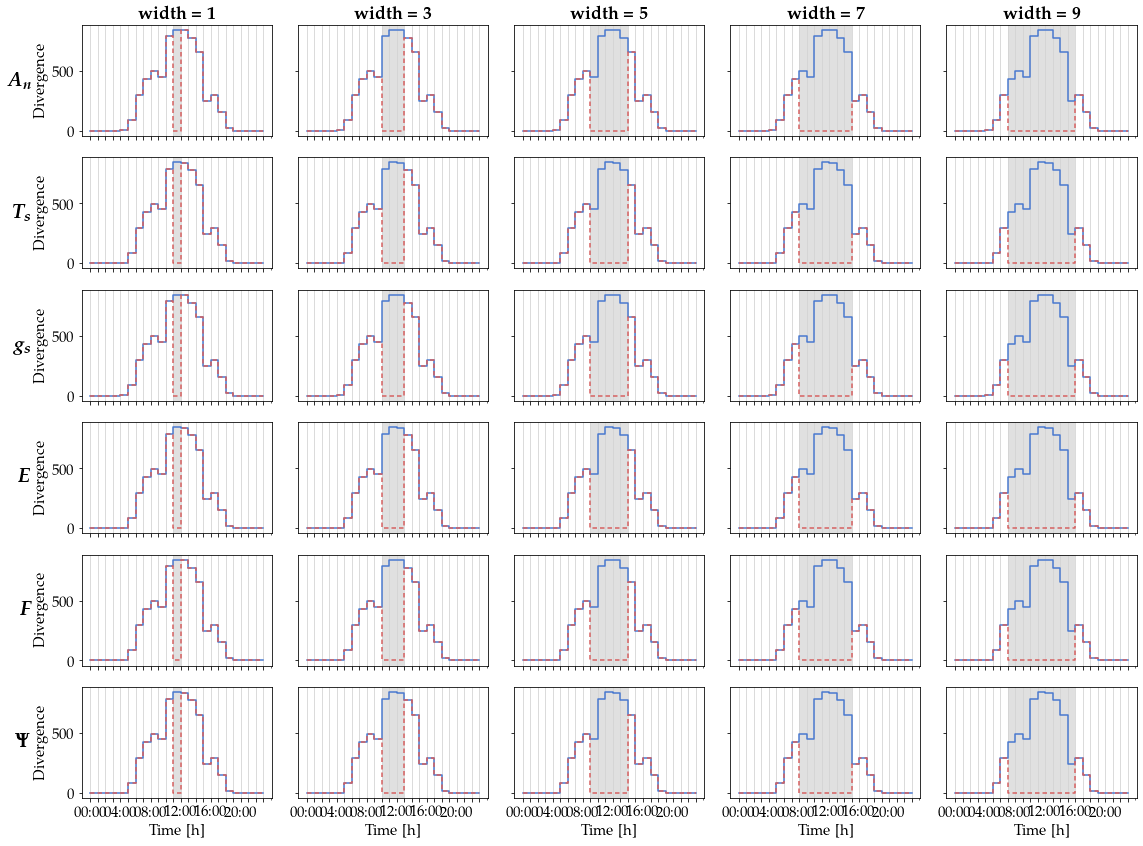

In [13]:
reservoirs = [
  'state_An',
  'state_Tlc',
  'state_gs',
  'state_E', 
  'state_Flux',
  'state_psi_head',
]

symbols = {
  'state_An': r'$A_n$',
  'state_Tlc': r'$T_s$',
  'state_gs': r'$g_s$',
  'state_E': r'$E$',
  'state_Flux': r'$F$',
  'state_psi_head': r'$\Psi$',
}

symbols_bold = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in symbols.items()}

widths = [1, 3, 5, 7, 9]

intervals = [
    (12, 13),  # width 1
    (11, 14),  # width 3
    (10, 15),  # width 5
    ( 9, 16),  # width 7
    ( 8, 17),  # width 9
 ]

baseline = '2012-08-01__width0__0'
template = lambda width, value: f'2012-08-01__width{width}__{value}'

START = 24 * 4
STOP = 24 * 5


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(16, 12), sharex=True, sharey=True)
  colors = sns.color_palette()

  for row, (state, axs_row) in enumerate(zip(reservoirs, axs)):
    for col, (width, (p0, p1), ax) in enumerate(zip(widths, intervals, axs_row)):
      # get data
      base = dataset.get_target('input_Rg', baseline)[START:STOP]
      experiment = dataset.get_target('input_Rg', template(width, 0))[START:STOP]
      base.index = np.arange(START, STOP)
      experiment.index = np.arange(START, STOP)

      # plot data
      base.plot(ax=ax, label="Baseline", drawstyle='steps-pre', color=colors[0])
      experiment.plot(ax=ax, dashes=(3, 2), label="Impulse", drawstyle='steps-pre', color=colors[2])  

      # color impulse steps
      ax.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15)

      # x axis
      xticks = np.arange(START, STOP, 1)
      ax.set_xticks(xticks)
      xticklabels = generate_xticklabels(xticks)
      xticklabels = [label if not (i + 4) % 4 else '' for i, label in enumerate(xticklabels)]
      ax.set_xticklabels(xticklabels)
      ax.grid(axis='x', linestyle='solid', color='lightgrey')

      # labeling
      ax.set_xlabel(r'Time [\unit{\hour}]')
      ax.set_ylabel(r'Divergence')

      if col == 0:
        ax.annotate(symbols_bold[state], (-0.27, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)

      if row == 0:
        ax.annotate(f'\\textbf{{width = {width}}}', (0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=18)


  plt.tight_layout()
  # plt.savefig('impulse_inputs_hydroshoot.png', dpi=200, facecolor='white')

